# Step 1
### Getting Airbnb Data
<br>

----

#### Download Index File

In [1]:
import os.path
from os import path
import requests

airbnb_data_url = "http://insideairbnb.com/get-the-data.html"
airbnb_data_path = "../data/airbnb.html"

if not path.exists(airbnb_data_path):
    cur_request = requests.get(airbnb_data_url, allow_redirects=True)
    open(airbnb_data_path, 'wb').write(cur_request.content)


#### Start City DataFrame

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import re

cur_soup = BeautifulSoup(open(airbnb_data_path), 'html.parser')

cur_cities_html = cur_soup.select("table.table")

city_dict = {}
cur_regex = r"See (.*) data visually here."

for cur_city_html in cur_cities_html:
    cur_slug = cur_city_html["class"][-1]
    
    cur_name = re.match(
        cur_regex, cur_city_html.findPreviousSibling("p").text
    ).groups()[0]
    
    city_dict[cur_slug] = cur_name

city_data = pd.DataFrame(
    index=city_dict.keys(), data=city_dict.values(), columns=["name"]
)

city_data.head(5)


,name
amsterdam,Amsterdam
antwerp,Antwerp
asheville,Asheville
athens,Athens
austin,Austin


----

#### Add Rental Urls

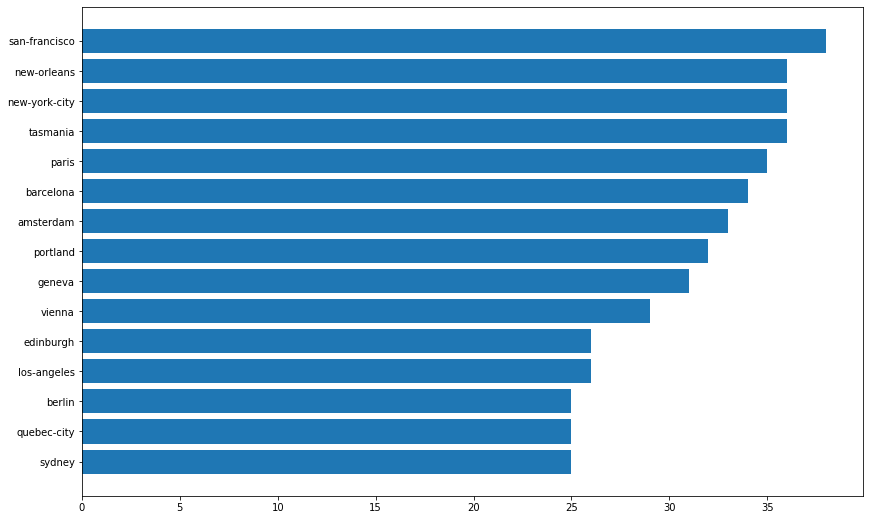

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

for cur_anchor in cur_soup.find_all('a', href=True):
    cur_anchor.replace_with(cur_anchor['href'])

cur_cities_urls = []
cur_cities_dates = []
cur_cities_geos = []

for cur_city_html in cur_cities_html:
    cur_city_table = pd.read_html(str(cur_city_html))[0]

    cur_city_geo = cur_city_table[cur_city_table["File Name"].str.endswith(".geojson")]["File Name"].iloc[0]
        
    cur_cities_geos.append(cur_city_geo)
    
    cur_city_table = cur_city_table[cur_city_table["File Name"].str.endswith("listings.csv.gz")]

    assert cur_city_table["Country/City"].nunique() == 1

    cur_city_table["Date Compiled"] = pd.to_datetime(cur_city_table["Date Compiled"], format="%d %B, %Y")

    cur_city_table = cur_city_table[cur_city_table["Date Compiled"].dt.year > 2016]

    cur_city_table = cur_city_table.drop_duplicates(subset="File Name")
    
    cur_cities_urls.append(cur_city_table["File Name"].tolist())
    cur_cities_dates.append(cur_city_table["Date Compiled"].tolist())
    
city_data["counts"] = list(map(len,cur_cities_urls))
city_data["urls"] = cur_cities_urls
city_data["dates"] = cur_cities_dates
city_data["geo_link"] = cur_cities_geos

top_cities = city_data[city_data.counts >= 12 + 12].sort_values(by="counts", ascending=False)

plt.figure(figsize=(14,9))
plt.barh(top_cities.index, top_cities.counts)
plt.gca().invert_yaxis()

plt.show()


----

#### Download Monthly Data

In [4]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm

def async_run(f, my_iter):
    with ThreadPoolExecutor(max_workers=6) as executor:
        results = list(tqdm(
            executor.map(f, my_iter), total=len(my_iter)
        ))
        
        return results
    
from time import sleep

def get_month_data(cur_file_tuple):
    cur_file_name, cur_file_link = cur_file_tuple
    if path.exists(cur_file_name): return
    
    month_data = pd.read_csv(cur_file_link, low_memory=False)
    
    month_data = month_data[month_data.room_type == "Entire home/apt"]
    month_data = month_data[month_data.property_type == "Apartment"]
    month_data = month_data[month_data.bed_type == "Real Bed"]

    month_data["price"] = month_data.price.str.replace(
        r"[\$\,]", ""
    ).astype(float).round(2)

    month_data = month_data[[
        'id', 'price', 'latitude', 'longitude', 
        'accommodates', 'bathrooms', 'bedrooms',
        'is_location_exact', 'number_of_reviews',
        'review_scores_rating', 'reviews_per_month'
    ]]

    month_data = month_data.reset_index(drop=True)
    month_data.to_csv(cur_file_name)
    
    sleep(0.01)
    

In [5]:
used_cities = city_data.loc[["san-francisco", "new-york-city", "paris", "berlin"]]

cur_file_names = []
cur_file_links = []

for cur_row in used_cities.itertuples():
    for cur_date, cur_file_link in zip(cur_row.dates, cur_row.urls):
        cur_file_name = "../data/cities/"
        cur_file_name += cur_row.Index.replace('-', '_')
        cur_file_name += "_"
        cur_file_name += cur_date.strftime('%Y_%m_%d')
        cur_file_name += ".csv"
        
        cur_file_names.append(cur_file_name)
        cur_file_links.append(cur_file_link)
        
        (cur_file_name, cur_file_link)

async_run(
    get_month_data, 
    list(zip(cur_file_names, cur_file_links))
);

#### Compile Data Down

In [6]:
def clean_work_table(work_table):
    work_table = work_table.dropna(subset=["price"])[work_table.price > 0]

    id_counts = work_table.groupby("id")["id"].count()
    
    work_table = pd.merge(
        id_counts.to_frame().rename(columns={"id": "weight"}),
        work_table, on="id"
    )

    bad_ids = id_counts[ id_counts <= 3 ]

    work_table = work_table[~work_table.id.isin(bad_ids.index)]

    work_table = pd.merge(
        work_table.groupby("id")["price"].aggregate(stats.hmean).round(2).to_frame(),
        work_table.drop(columns="price").drop_duplicates(subset="id"),
        on="id"
    ).drop(columns=["id"])

    work_table = work_table[work_table.is_location_exact == "t"].drop(columns="is_location_exact")

    work_table = work_table.dropna()

    work_table = work_table[ work_table["reviews_per_month"] > 1/8 ]

    work_table = work_table[ work_table["number_of_reviews"] > 5 ]

    work_table = work_table[ work_table["review_scores_rating"] > 80 ]

    work_table = work_table.drop(columns=[
        "reviews_per_month",
        "number_of_reviews", 
        "review_scores_rating"
    ])

    work_table = work_table.reset_index(drop=True)
    
    work_table = work_table[work_table.accommodates >= 1]
    work_table = work_table[work_table.accommodates <= 8]

    work_table = work_table[work_table.bathrooms >= 1 ]
    work_table = work_table[work_table.bathrooms <= 4 ]

    work_table = work_table[ work_table.bedrooms >= 1 ]
    work_table = work_table[ work_table.bedrooms <= 4 ]

    price_bin_count = 20

    city_price_bins = pd.qcut(work_table.price, price_bin_count, False)

    work_table = work_table.loc[
        city_price_bins[
            ( city_price_bins > 0 ) &
            ( city_price_bins < price_bin_count-1 ) 
        ].index
    ]
    
    work_table["bedrooms"] = work_table.bedrooms.astype(int)

    return work_table


In [7]:
import glob
from datetime import datetime

from scipy import stats

rental_data_list = []

for cur_row in used_cities.itertuples():
    cur_glob = glob.glob(
        f"../data/cities/{cur_row.Index.replace('-', '_')}*.csv"
    )
    
    assert cur_row.counts == len(cur_glob)
    
    work_table = None
              
    for cur_file in cur_glob:
        cur_date = datetime.strptime(
            re.search(r"(\d{4}_\d{2}_\d{2})\.csv", cur_file).group(1),
            '%Y_%m_%d'
        )
        
        work_sub_table = pd.read_csv(cur_file).drop(columns="Unnamed: 0")
        work_sub_table["date"] = cur_date

        if work_table is None:
            work_table = work_sub_table
        else:
            work_table = pd.concat([work_table, work_sub_table])

    work_table = work_table.sort_values(
        by=["id", "date"], ascending=[True, False]
    ).drop(columns="date")
    
    work_table = clean_work_table(work_table)
    
    rental_data_list.append(work_table)
    
used_cities["rentals"] = rental_data_list


#### Get Geo Data

In [8]:
import geopandas 
from shapely.ops import unary_union

geo_data_list = []
for cur_row in used_cities.itertuples():
    cur_geo_link = city_data.loc[cur_row.Index].geo_link
    cur_geo_file = f"../data/geo/{cur_row.Index.replace('-', '_')}.geojson"
    
    if not path.exists(cur_geo_file): 
        cur_request = requests.get(cur_geo_link, allow_redirects=True)
        open(cur_geo_file, 'wb').write(cur_request.content)

    tmp_geo_data = geopandas.read_file(cur_geo_file)
    
    if cur_row.Index == "new-york-city":
        sub_geo = geopandas.read_file(
            "http://data.ci.newark.nj.us/dataset/db87f66a-6d79-4933-9011-f392fdce7eb8/resource/95db8cad-3a8c-41a4-b8b1-4991990f07f3/download/njcountypolygonv2.geojson"
        )

        sub_geo = sub_geo[sub_geo.geometry.centroid.y > 40]
        sub_geo = sub_geo[sub_geo.geometry.centroid.x > -75]
        
        sub_geo = sub_geo[["county", "statefp", "geometry"]]
        sub_geo["statefp"] = "New Jersey"
        sub_geo.columns = tmp_geo_data.columns
        
        tmp_geo_data = pd.concat([tmp_geo_data, sub_geo])
        
    geo_data_list.append(tmp_geo_data)
    
used_cities["geo"] = geo_data_list


In [9]:
metro_list = []

for cur_row in used_cities.itertuples():
    cur_metro_file = f"../data/geo/trains/{cur_row.Index.replace('-', '_')}.geojson"    
    assert path.exists(cur_metro_file)

    tmp_metro_data = geopandas.read_file(cur_metro_file)

    if cur_row.Index in ["paris", "berlin"]:
        tmp_metro_data = tmp_metro_data[tmp_metro_data.route_type < 3]
        
    metro_list.append(tmp_metro_data)
    
used_cities["metro"] = metro_list

#### Save Pickle File

In [10]:
used_cities = used_cities.drop(
    columns=["counts", "urls", "dates", "geo_link"]
)

used_cities.to_pickle("../data/pickles/cities_1.pkl")

In [11]:
dict(zip(used_cities.name, list(map(len,used_cities.rentals))))


{'San Francisco': 1927, 'New York City': 13374, 'Paris': 28829, 'Berlin': 5668}